In [1]:
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import GaussianBlur

from src import dino

DOWNSAMPLE_RATIO = 4


def clip_and_get_brightness(image, white_nits):
    # Clip results to (0, 1)
    zeros = torch.zeros(image.size()).to(image.device)
    image = torch.maximum(image, zeros)
    ones = torch.full(image.size(), 1).to(image.device)
    image = torch.minimum(image, ones)
    # Compute brightness response
    L = dino.fairchild_to_relative_luminance(image) * white_nits
    brightness_response = dino.pytorch.dn_brightness_model(L)
    return brightness_response.unsqueeze(0)


class ReinhardModel(nn.Module):
    def __init__(self, key=0.18, l_white=0.5, gamma=2.2, white_nits=200):
        super(ReinhardModel, self).__init__()
        self.weights = nn.Parameter(torch.Tensor([key, l_white]))
        self.gamma = gamma
        self.white_nits = white_nits

    def forward(self, x):
        # Apply Reinhard tone mapper
        key, l_white = self.weights
        x = (key / torch.mean(x ** 1.0/self.gamma) ** self.gamma) * x
        tonemapped_x = torch.squeeze(x / (1 + x / (l_white**2)))
        return clip_and_get_brightness(tonemapped_x, self.white_nits)


class BrightnessDataset(torch.utils.data.Dataset):

    def __init__(self, input_dir, target_dir):
        self.input_file_paths = sorted(f for f in Path(input_dir).iterdir() if f.is_file())
        self.target_file_paths = sorted(f for f in Path(target_dir).iterdir() if f.is_file())

        assert all(
            self.input_file_paths[i].stem == self.target_file_paths[i].stem
            for i in range(len(self.input_file_paths))
        )

    def __len__(self):
        return len(self.input_file_paths)

    def __getitem__(self, idx):
        input_image = dino.read_image(str(self.input_file_paths[idx]))
        input_image = dino.resize_image(input_image, resize_width=round(input_image.shape[1]/DOWNSAMPLE_RATIO))
        brightness_response = np.load(self.target_file_paths[idx])
        return input_image, brightness_response

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device is {device}")
model = ReinhardModel().to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

train_set = BrightnessDataset("training/images", "training/brightnesses")
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True)

Device is cuda


In [3]:
CHECKPOINT_PATH = Path("training/checkpoints")

def checkpoint_file_path(epoch):
    return str(CHECKPOINT_PATH / f"rein-epoch{epoch}.pickle")

start_epoch = 9
if start_epoch == 0:
    checkpoint = dict(
        state_dict={},
        train_losses=[],
        train_errors=[],
    )
else:
    checkpoint = torch.load(checkpoint_file_path(start_epoch), weights_only=False)
    model.load_state_dict(checkpoint["state_dict"])
    print(f"Loaded model from checkpoint at epoch {start_epoch}.")

e = start_epoch

Loaded model from checkpoint at epoch 9.


In [5]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm


max_epochs = 500

while e < max_epochs:
    train_losses = []
    for sample, brightness in tqdm(train_loader, desc=f"Epoch {e}"):
        sample = sample.to(device)
        brightness = brightness.float().to(device)
        prediction = model(sample)
        loss = loss_fn(prediction, brightness)
        train_losses.append(loss.detach().cpu().item())
        optim.zero_grad()
        loss.backward()
        optim.step()

        # CMAP = "viridis"
        # fig, axs = plt.subplots(1,2,figsize=(12,6))
        # target = np.squeeze(brightness.detach().cpu().numpy())
        # pred = np.squeeze(prediction.detach().cpu().numpy())
        # vmin = np.min(pred)
        # vmax = np.max(pred)
        # im = axs[0].imshow(target, vmin=vmin, vmax=vmax, cmap=CMAP)
        # axs[0].set_title("Original Brightness")
        # axs[1].imshow(pred, vmin=vmin, vmax=vmax, cmap=CMAP)
        # axs[1].set_title("ACES Brightness")
        # fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)

    checkpoint["state_dict"] = model.state_dict()
    checkpoint["train_losses"].append(np.mean(train_losses))
    checkpoint["train_errors"].append([np.min(train_losses), np.max(train_losses)])
    torch.save(checkpoint, checkpoint_file_path(e))
    print(f"Average training loss: {checkpoint["train_losses"][-1]}")
    e += 1

Epoch 9:   0%|          | 0/27 [00:00<?, ?it/s]

KeyboardInterrupt: 

[0.00865147 0.9971323 ]


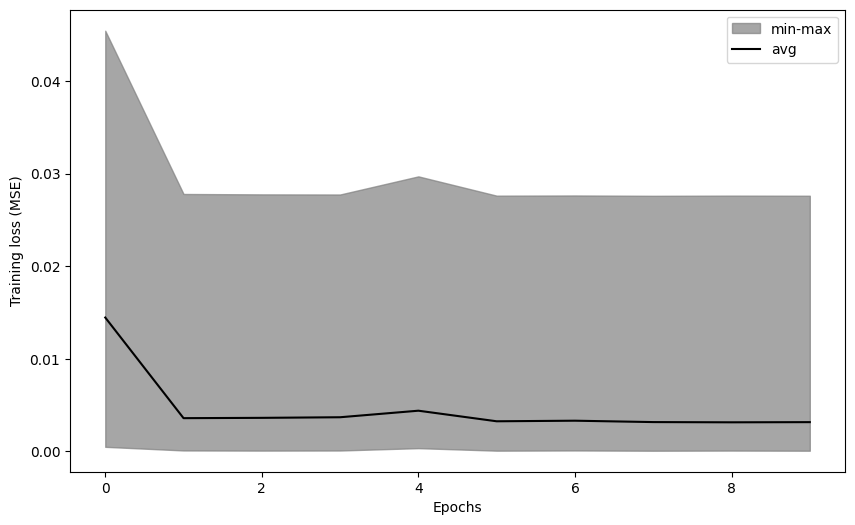

In [6]:
x_range = list(range(len(checkpoint["train_losses"])))
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.set_xlabel("Epochs")
ax.set_ylabel("Training loss (MSE)")
ax.fill_between(
    x_range,
    [y2 for _, y2 in checkpoint["train_errors"]],
    y2=[y1 for y1, _ in checkpoint["train_errors"]],
    color="grey",
    label="min-max",
    alpha=0.7,
)
ax.plot(x_range, checkpoint["train_losses"], "k-", label="avg")
_ = ax.legend()

print(model.weights.detach().cpu().numpy())

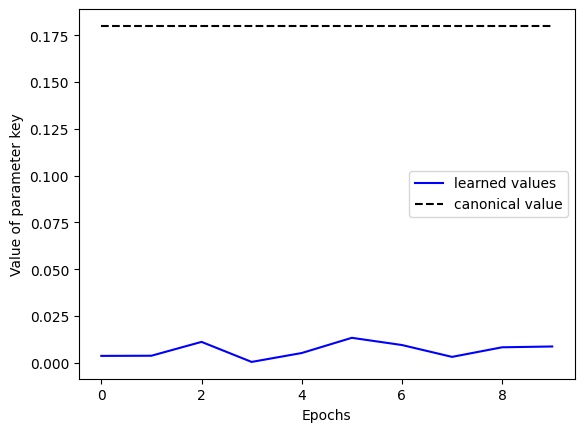

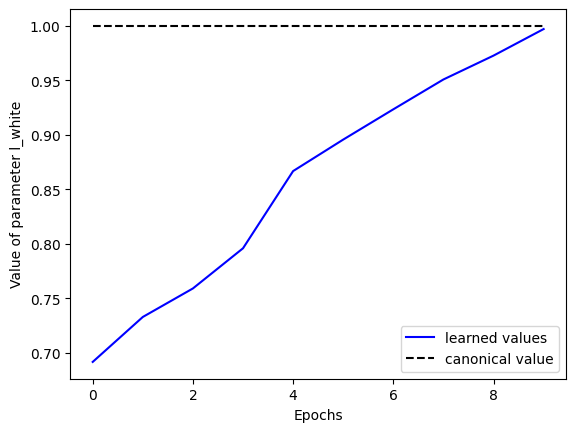

In [7]:
# Compare learning to "canonical" ACES coefficients from
# https://knarkowicz.wordpress.com/2016/01/06/aces-filmic-tone-mapping-curve/
params = ["key", "l_white"]
canonical_values = dict(zip(params, [0.18, 1.0]))

learned_params = {p: [] for p in params}
num_epochs = 12
x_values = []
for epoch in range(num_epochs):
    epoch_file_path = checkpoint_file_path(epoch)
    if not Path(epoch_file_path).is_file():
        continue
    model.load_state_dict(torch.load(epoch_file_path, weights_only=False)["state_dict"])
    for p, value in zip(params, model.weights.detach().cpu().numpy(), strict=True):
        learned_params[p].append(value)
    x_values.append(epoch)
    
for param, learned_values in learned_params.items():
    fig, ax = plt.subplots()
    ax.set_xlabel("Epochs")
    ax.set_ylabel(f"Value of parameter {param}")
    ax.plot(x_values, learned_values, "b-", label="learned values")
    ax.plot(x_values, [canonical_values[param] for _ in x_values], "k--", label="canonical value")
    ax.legend()

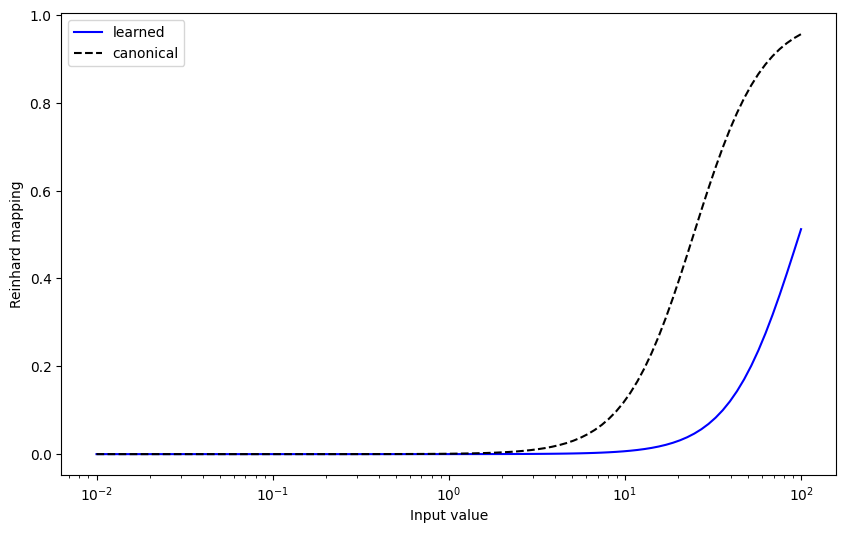

In [8]:
import matplotlib.pyplot as plt
from src.tone_mappers.reinhard import reinhard

epoch_to_use = 9
model.load_state_dict(torch.load(checkpoint_file_path(epoch_to_use), weights_only=False)["state_dict"])

x_range = np.logspace(-2, 2, num=100, base=10)
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.set_xlabel("Input value")
ax.set_xscale("log")
ax.set_ylabel("Reinhard mapping")
ax.plot(x_range, reinhard(x_range, *model.weights.detach().cpu().numpy()), "b-", label="learned")
ax.plot(x_range, reinhard(x_range, *list(canonical_values.values())), "k--", label="canonical")
ax.legend()

In [10]:
params_set = [
    # Canonical
    list(canonical_values.values()),
    # Learned
    model.weights.detach().cpu().numpy(),
]

data_dir = Path("training")
for params in params_set:
    for file in (data_dir / "images").iterdir():
        if not file.suffix in [".hdr", ".exr"]:
            continue
        image = dino.read_image(str(file))
        tonemapped = reinhard(image, *params)
        key, l_white = params
        output_path = str(data_dir / "tonemapped" / f"{file.stem}_reinhard_key={key}_lwhite={l_white}.png")
        dino.write_image(output_path, tonemapped)
        print(f"Saved {output_path}")

Saved training/tonemapped/MirrorLake_reinhard_key=0.18_lwhite=1.0.png
Saved training/tonemapped/TupperLake(1)_reinhard_key=0.18_lwhite=1.0.png
Saved training/tonemapped/MasonLake(2)_reinhard_key=0.18_lwhite=1.0.png
Saved training/tonemapped/MammothHotSprings_reinhard_key=0.18_lwhite=1.0.png
Saved training/tonemapped/DevilsTower_reinhard_key=0.18_lwhite=1.0.png
Saved training/tonemapped/BenJerrys_reinhard_key=0.18_lwhite=1.0.png
Saved training/tonemapped/YosemiteFalls_reinhard_key=0.18_lwhite=1.0.png
Saved training/tonemapped/NorthBubble_reinhard_key=0.18_lwhite=1.0.png
Saved training/tonemapped/PaulBunyan_reinhard_key=0.18_lwhite=1.0.png
Saved training/tonemapped/BarHarborPresunrise_reinhard_key=0.18_lwhite=1.0.png
Saved training/tonemapped/RITTiger_reinhard_key=0.18_lwhite=1.0.png
Saved training/tonemapped/OtterPoint_reinhard_key=0.18_lwhite=1.0.png
Saved training/tonemapped/DevilsBathtub_reinhard_key=0.18_lwhite=1.0.png
Saved training/tonemapped/MackinacBridge_reinhard_key=0.18_lwhit